# Predicting a thresholded 'OtherPay' salary component of SF city workers in 2012
<i>By Diego Ramallo</i>

Kaggle recently released <a href='https://www.kaggle.com/kaggle/sf-salaries'> salary data</a> for public servants of the city of San Francisco. To put things into context: SF is among the <a href='http://www.economist.com/blogs/graphicdetail/2015/11/daily-chart-0'>most expensive places to live in America.</a> Not surprisingly, the <a href='http://www.census.gov/quickfacts/table/PST045214/06075'> median household income</a> is also among the <a href='http://www.mercurynews.com/business/ci_26312024/santa-clara-county-has-highest-median-household-income'> highest in the nation.</a> The Kaggle dataset reports on the salaries of ~148,000 public employees and provides information under the categories of: <strong>ID, EmployeeName, JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, and TotalPayBenefits </strong> for 2011-2014.  

<strong>Otherpay</strong> is a mysterious category since it doesn't qualify as overtime or benefits pay, but it can be SUBSTANTIAL, often dwarfing basepay. Since there are no additional details on what it covers, one could imagine inefficient expenses being listed under this category. And in a city with a <a href='http://www.sfchronicle.com/bayarea/matier-ross/article/Skyrocketing-pension-costs-putting-S-F-in-the-red-6680080.php?t=ac4d4fa181&cmpid=twitter-premium'> large deficit</a> despite a booming economy, it would be useful to see who is more likely to exceed their BasePay with OtherPay. 

Here, <strong>I found that a 3 feature random forest classifier outperforms a logistic regression classifier</strong> in predicting what 2012 SF employees will receive extremely high contributions to their salaries from OtherPay.

<a href='#load'>Loading and preprocessing data</a>
<p></p>
<a href='#split'>Splitting data</a>
<p></p>
<a href='#visualize'>Visualizing data</a>
<p></p>
<a href='#consolidate'>Consolidating data</a>
<p></p>
<a href='#sklearn'>Modeling and training our data</a>
<p></p>
<a href='#validate'>Prediction results and model validation</a>
<p></p>
<a href='#robustness'>Check robustness of model</a>
<p></p>
<a href='#summary'>Summary and conclusions</a>

<a id='load'></a>

## Loading and preprocessing data

In [16]:
import warnings
warnings.filterwarnings('ignore')#Many warnings would pop up that clutter our notebook, this commands disables them
import sqlite3#Used to access database
import pandas as pd#Used to load data as dataframes
import numpy as np#Used for math and array operations
import matplotlib.pyplot as plt#Used for plotting
import seaborn as sns#Also used for plotting, friendly with dataframes

In [2]:
#Create connection to SQLite database
con= sqlite3.connect('sf_salaries.sqlite')

#Use pandas to query database
data= pd.read_sql_query('''SELECT JobTitle, BasePay, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year FROM Salaries
''',con)

In [3]:
data.head(1)#Preview

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011


Let's see if length of title affects salary variables, we'll measure the length of titles and append list of lengths to dataframe.


In [4]:
titles= data['JobTitle'].tolist()

titleLen= []
for i in range(0,len(titles)):
    titleLen.append(len(titles[i])-1)#-1 because we have unicode string 'u' in front

lenSeries= pd.Series(titleLen) #Convert list to series
print len(data),len(lenSeries)#Doublecheck that they're the same lengths

148654 148654


In [5]:
data['TitleLen']= lenSeries#Append series to dataframe
data.tail(5)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,TitleLen
148649,Custodian,0,0,0,0,0.00,0.00,2014,8
148650,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148651,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148652,Not provided,Not Provided,Not Provided,Not Provided,Not Provided,0.00,0.00,2014,11
148653,"Counselor, Log Cabin Ranch",0,0,-618.13,0,-618.13,-618.13,2014,25


As you can see above, there are many cells in our table where information is 'Not Provided'. We need to exclude rows that contain this text in order to performs mathematical operations on the Series/columns where they sit. Additionally, closer inspection of the 'data' dataframe shows that the year 2011 <strong>does not include values for Benefits or TotalPayBenefits</strong>. Thus, we'll limit the data to build our model to years 2012-2014 in order to keep our dataset uniform, and in the process also adjust our data types in order to perform additional statistical learning operations on it.

In [6]:
dataClean= data[(data['BasePay'] != 'Not Provided') & (data['Year'] != 2011)]
dataClean.tail(5)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,TitleLen
148645,Human Services Technician,0,0,0,0,0.00,0.00,2014,24
148647,Communications Dispatcher 2,0,0,0,0,0.00,0.00,2014,26
148648,Custodian,0,0,0,0,0.00,0.00,2014,8
148649,Custodian,0,0,0,0,0.00,0.00,2014,8
148653,"Counselor, Log Cabin Ranch",0,0,-618.13,0,-618.13,-618.13,2014,25


In [7]:
#Finally, let's check that our numeric sets are all numeric and consistent
dataClean.dtypes

JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
TitleLen              int64
dtype: object

In [9]:
#Since they're not all numerical, we'll need to convert the remaining ones (BasePay requires special conversion, see next line)
dataClean['OvertimePay']= dataClean['OvertimePay'].astype(np.float64)
dataClean['OtherPay']= dataClean['OtherPay'].astype(np.float64)
dataClean['Benefits']= dataClean['Benefits'].astype(np.float64)
dataClean['TotalPay']= dataClean['TotalPay'].astype(np.float64)
dataClean['Year']= dataClean['Year'].astype(np.float64)

In [11]:
#BasePay and TitleLen do not get converted to the right datatype using the above operations, we need special conversion operations:
dataClean['BasePay'] = dataClean['BasePay'].convert_objects(convert_numeric=True)

In [13]:
dataClean.dtypes

JobTitle             object
BasePay             float64
OvertimePay         float64
OtherPay            float64
Benefits            float64
TotalPay            float64
TotalPayBenefits    float64
Year                float64
TitleLen              int64
dtype: object

Now that the data types are all numerical, we can proceed with model building. Since we have three years' worth of data, let's use the first year, 2012, to train our data. We can then begin to apply this model to additional years if we choose to do so later.

<a id='split'></a>

## Splitting data

In [14]:
clean2012= dataClean[dataClean['Year'] == 2012]#Filter out non-2012 data.
clean2012= clean2012.drop(['Year'], axis= 1)#Since we know it is from 2012, we don't need a 2012 column anymore.

In [15]:
from sklearn.cross_validation import train_test_split
train2012, test2012 = train_test_split(clean2012, test_size = 0.2)
train2012.tail(2)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen
41663,"Sr Statnry Eng, Wtr Treat Plnt",90776.97,17141.18,17138.37,41895.65,125056.52,166952.17,29
59032,Porter,51502.00,5908.33,624.00,27165.60,58034.33,85199.93,5


<a id='visualize'></a>

## Visualizing our data

Using a pairplot, let's observe the relationship between OtherPay and the numerical features that are <strong>NOT</strong> sums of any of the other component features (eg. TotalPay and TotalPayBenefits). We'll then generate a <strong>correlation matrix</strong> between our features and the OtherPay response to quantitate the strength of their relationship.

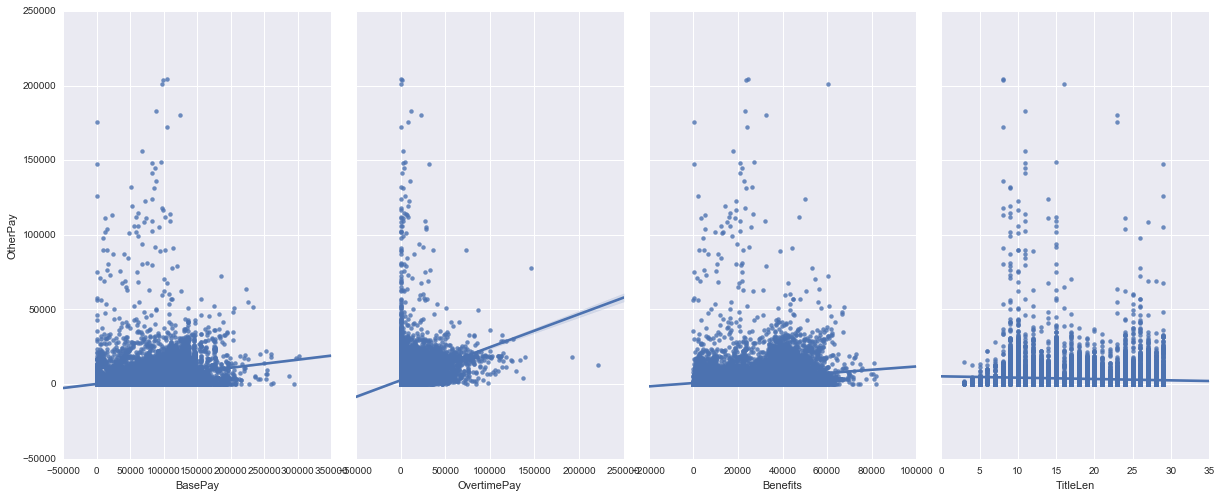

In [16]:
%matplotlib inline
sns.pairplot(train2012, 
             x_vars= ['BasePay','OvertimePay','Benefits','TitleLen'], 
             y_vars= 'OtherPay', size= 7, aspect= 0.6, 
             kind= 'reg')

In [17]:
train2012[['BasePay','OvertimePay','Benefits','TitleLen','OtherPay']].corr()#Correlation matrix for features and response

,BasePay,OvertimePay,Benefits,TitleLen,OtherPay
BasePay,1.000000,0.278505,0.911993,-0.011487,0.287914
OvertimePay,0.278505,1.000000,0.274345,-0.021360,0.320869
Benefits,0.911993,0.274345,1.000000,0.012486,0.221170
TitleLen,-0.011487,-0.021360,0.012486,1.000000,-0.073398
OtherPay,0.287914,0.320869,0.221170,-0.073398,1.000000


Our plots are quite noisy, but do show some weak <strong>linear relationships</strong> between the features and the response. It is also clear that there is a subset of employees that are making more money from OtherPay than from BasePay (what one assumes should be the largest contributor to their salary, left panel). The correlation matrix validates that aside from BasePay and Benefits, most features only have a weak to moderate correlation with OtherPay and one another. 

<a id='consolidate'></a>

## Consolidating  data

A large fraction of the employees receive OtherPay, but we're interested in those that may receive <i>excessive</i> OtherPay payments. Thus, if we set an OtherPay compensation threshold for employees with OtherPays that are approximately <u>(> 90%)</u> as large as their BasePay, we can make a dummy variable that returns a <strong>categorical response</strong>. In this case, 1 if it is above the 90% threshold, and 0 if it is below it.


In [17]:
basePayTrain= np.array(train2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTrain= np.array(train2012['OtherPay'])
excessThresh= []; #ExcessThresh= otherPay > 0.9*basePay, equals 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTrain)):
    
    if 0.9*basePayTrain[i] <= otherPayTrain[i]:#Choosing OtherPay values greater than 90% of BasePay
        excessThresh.append(1)
    else:
        excessThresh.append(0)
        
#Let's doublecheck that excess only has 0 or 1 values:
np.unique(excessThresh)

array([0, 1])

Excellent, now let's visualize what data excessThresh covers (OtherPay > 90% of BasePay) plotted over our original BasePay vs OtherPay plot. We'll have to filter our BasePayTrain and OtherPayTrain variables to remove all the zeros in our data.

In [18]:
otherPayTrainThresh= np.array(excessThresh)*otherPayTrain#Masking OtherPay with results from excess
otherPayTrainThreshNo0= otherPayTrainThresh[otherPayTrainThresh!=0]#Remove all rows with zero

basePayTrainThreshNo0= basePayTrain[otherPayTrainThresh!=0]#Remove all rows where otherPayTrainThresh = 0

<IPython.core.display.Javascript object>


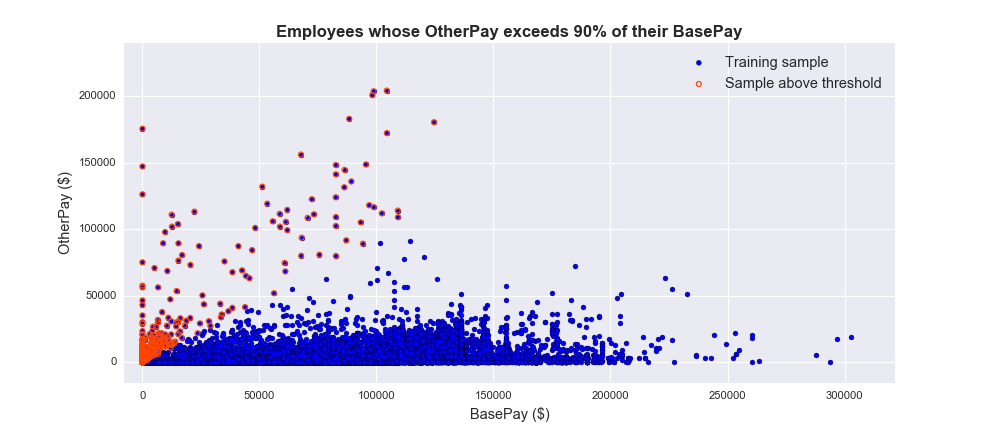

There are 552 employees who make approximately as much from from "OtherPay" as from their "BasePay".
The sum of their "OtherPay" wages is $ 11117207.87


In [40]:
#Let's see what portion of the employees for into the 'thresh' category on our BasePay vs OtherPay plot
%matplotlib nbagg
legendOtherPay= plt.scatter(basePayTrain,train2012['OtherPay'], label= 'Training sample')
legendExvalue= plt.scatter(basePayTrainThreshNo0,otherPayTrainThreshNo0, color= 'orangered', facecolor= 'None', 
                           linewidths= 1.1, label= 'Sample above threshold')#Masked out OtherPay appears as zero on plot
plt.xlabel('BasePay ($)', fontsize= 13); 
plt.ylabel('OtherPay ($)', fontsize= 13); plt.legend(handles=[legendOtherPay, legendExvalue], fontsize= 13)
plt.title('Employees whose OtherPay exceeds 90% of their BasePay',  fontweight= 'bold', fontsize= 15)
print 'There are', sum(excessThresh), 'employees who make approximately as much from from "OtherPay" as from their "BasePay".'
print 'The sum of their "OtherPay" wages is $', sum(otherPayTrainThresh)

So 552 employees earn OtherPay that is greater than or equal to 90% of their BasePay, and this equals about 11 million dollars. To put that into context, SF spent <a href='http://www.nytimes.com/2016/02/05/us/super-bowl-50-further-divides-san-francisco.html?_r=0'>$5 million</a> on putting the Superbowl together in 2016, and as you may recall, this only covers our training set. From the plot above we can also see that they are generally employees who fall below the center of the distribution in our training set. Now let's add the categorial results from excess to our dataframe as <strong>'ThreshPay'</strong>.

In [27]:
train2012['ThreshPay']= excessThresh
train2012.tail(3)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen,ThreshPay
52289,Transit Fare Inspector,64250.99,2991.27,4912.90,37036.51,72155.16,109191.67,21,0
41663,"Sr Statnry Eng, Wtr Treat Plnt",90776.97,17141.18,17138.37,41895.65,125056.52,166952.17,29,0
59032,Porter,51502.00,5908.33,624.00,27165.60,58034.33,85199.93,5,0


Finally, we'll do the <strong>same for our testing dataset</strong>. Once this is finished we can train and test our model!

In [29]:
basePayTest= np.array(test2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTest= np.array(test2012['OtherPay'])
excessTestThresh= [];#Excess= 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTest)):
    
    if 0.9*basePayTest[i] <= otherPayTest[i]:#Choosing OtherPay values greater than 90% of BasePay
        excessTestThresh.append(1)
    else:
        excessTestThresh.append(0)
test2012['ThreshPay']= excessTestThresh#Adding list as a column to test2012 testing dataset

<a id='sklearn'></a>

## Modeling and training our data

Now that we have consolidated our responses into 'ThreshPay' and added it to our dataset, we can make and train our model, and finally use it to make predictions on the test dataset. Let's begin by organizing our features and responses (x and y, respectively) into separate dataframes for both the training and testing sets.

In [30]:
xTrain2012= train2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTrain2012= train2012[['ThreshPay']]

xTest2012= test2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTest2012= test2012[['ThreshPay']]

In [31]:
xTrain2012.tail(1)#Checking that we have the appropriate features

,BasePay,OvertimePay,Benefits,TitleLen
59032,51502,5908.33,27165.6,5


Since our feature set, xTrain2012, is relatively small, and we saw some linear relationships between our features and OtherPay, let's assume we can model our relationship with a linear model, using <strong>logistic regression</strong> and <strong>random forests</strong> methods, and <i>with and without</i> TitleLen (which in general has the weakest correlation coefficients). Using the Scikit-Learn Package, we'll need to create objects for each of the four conditions, train/fit the models using our training data, and finally make predictions using features from our testing data.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#Initialize model objects for all four situations
logmod= LogisticRegression()#Include all four features
logmod2= LogisticRegression()#All features but TitleLen
forest= RandomForestClassifier(n_estimators= 100)#Include all four features
forest2= RandomForestClassifier(n_estimators= 100)#All features but TitleLen

In [33]:
#Train the models 
logfit= logmod.fit(xTrain2012,yTrain2012)
logfit2= logmod2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)
forfit= forest.fit(xTrain2012,yTrain2012)
forfit2= forest2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)

In [34]:
#Make predictions using the test datasets
logpred= logfit.predict(xTest2012)#Prediction for 4 features
logpred2= logfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])#Prediction for 3 features
forpred= forfit.predict(xTest2012)
forpred2= forfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])

<a id='validate'></a>

## Prediction results and model validation

Now that we have predictions generated by our four models, we can generate metrics that will tell us about their accuracy. First, we'll measure an accuracy score between 0 and 1 for our predictions compared to the true results.

In [198]:
#Use metrics to measure the accuracy of our predictions compared to the true results in yTest2012
print '4-Feat. Log. Reg. model accuracy: ', accuracy_score(yTest2012,logpred)#Accuracy score for 4 features
print '3-Feat. Log. Reg. model accuracy: ', accuracy_score(yTest2012,logpred2)#Score for 3 features
print '4-Feat. Random Forest model accuracy: ', accuracy_score(yTest2012,forpred)
print '3-Feat. Random Forest model accuracy: ', accuracy_score(yTest2012,forpred2)

4-Feat. Log. Reg. model accuracy:  0.981370682622
3-Feat. Log. Reg. model accuracy:  0.992929018221
4-Feat. Random Forest model accuracy:  0.994560783247
3-Feat. Random Forest model accuracy:  0.994696763666


The accuracy scores are all extremely high, and of similar magnitude. It may help to visualize differences in their performance with a <strong>confusion matrix</strong> which will give us statistics on True positives, True negatives, False positives, and False negatives. We will then normalize the confusion matrices to make it easier to compare between models.

In [35]:
cmLog= confusion_matrix(yTest2012,logpred)#Confusion matrix for logistic regression model (4 features)
cmLogNorm = cmLog.astype('float') / cmLog.sum(axis=1)[:, np.newaxis]#Normalized model

cmLog2= confusion_matrix(yTest2012,logpred2)
cmLog2Norm = cmLog2.astype('float') / cmLog2.sum(axis=1)[:, np.newaxis]#Fraction of cell when matrix summed along rows

cmForpred= confusion_matrix(yTest2012,forpred)
cmForpredNorm = cmForpred.astype('float') / cmForpred.sum(axis=1)[:, np.newaxis]

cmForpred2= confusion_matrix(yTest2012,forpred2)
cmForpred2Norm = cmForpred2.astype('float') / cmForpred2.sum(axis=1)[:, np.newaxis]

The confusion matrix returns a 2x2 matrix. Now let's visualize the four matrices to see if we can identify the most useful models.

<IPython.core.display.Javascript object>


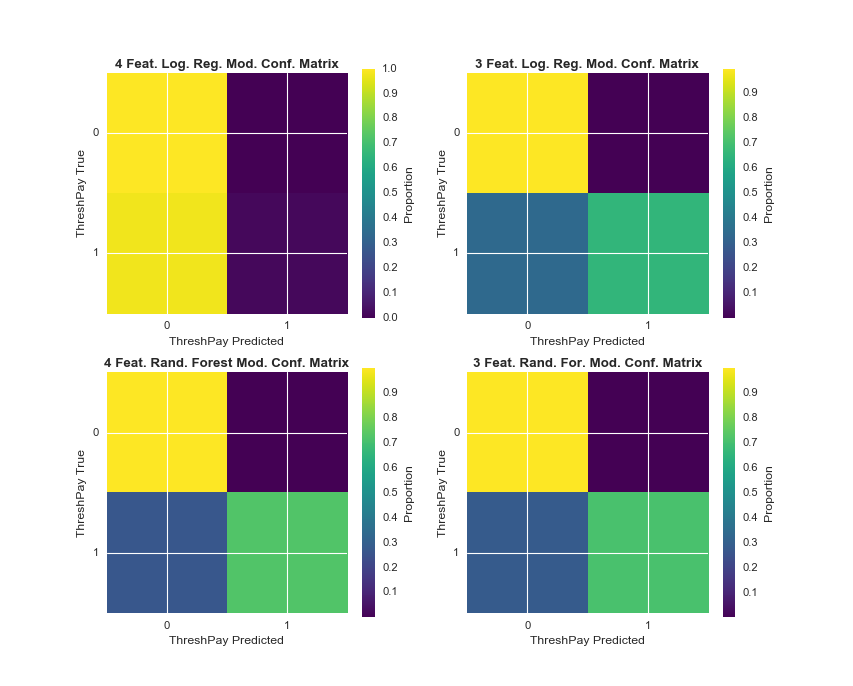

In [42]:
plt.subplot(2,2,1)
plt.imshow(cmLogNorm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('4 Feat. Log. Reg. Mod. Conf. Matrix', fontweight= 'bold')

plt.subplot(2,2,2)
plt.imshow(cmLog2Norm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('3 Feat. Log. Reg. Mod. Conf. Matrix', fontweight= 'bold')


plt.subplot(2,2,3)
plt.imshow(cmForpredNorm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('4 Feat. Rand. Forest Mod. Conf. Matrix', fontweight= 'bold' )

plt.subplot(2,2,4)
plt.imshow(cmForpred2Norm, interpolation='nearest', cmap='viridis')
plt.ylabel('ThreshPay True')
plt.xlabel('ThreshPay Predicted')
plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('3 Feat. Rand. For. Mod. Conf. Matrix', fontweight= 'bold')

To remind you, ThreshPay response is binary: above (1) or below (0) the BasePay threshold. The confusion matrices are a 2x2 grid with our Predicted ThreshPay values on the x-axis, and True ThreshPay values from the test set on the y-axis. <strong>Thus, accurate predictions sit diagonally while inaccurate predictions sit off-diagonally</strong>. The colorbar describes the normalized, cumulative probabilities of each of four outcomes for each model.
<p></p>
Though the accuracy score for all models were high, not all models categorized the samples properly. The four feature logistic regression model (top left) stands out because though it correctly predicted essentially all of the 0's (top left quadrant), it predicted few of the 1's (bottom right quadrant). In comparison, the remaining models had more accurate predictions of 1's and  of very similar magnitudes. This brings us to our next point.
<p></p>
Trimming our features from four to three improved our prediction accuracies, dramatically in the case of the logistic regression model. This means that the <strong>TitleLen</strong> feature that we initially added to our feature set really was not predictive of <strong>ThreshPay</strong>, but also that <u>the random forest model was much more robust against this bad feature than the logistic regression model</u>. 
<p></p>
Given that <strong>three features</strong> gives more accurate predictions than four, should we choose to use logistic regression or the random forest model as we move forward? The answer usually depends on the decision to <strong>predict</strong> responses or to <strong>infer</strong> the intricacies of the model's components more thoroughly. Since I'm more interested in prediction for the time being, I'll mostly be concerned with the model's accuracy. For this purpose, an <strong>ROC curve</strong> will be ideal since it will tell us about the rate of true positives relative to false positives.

<a id='robustness'></a>

## Check robustness of model

A receiver operating characteristic (ROC) curve plots the true positive rate (<strong>TPR</strong>) against the false positive rate (<strong>FPR</strong>). In order to generate the plot, we need to calculate the <strong>predicted probabilities</strong> (calculated probabilities used to determine predicted responses) for each model. Using the predicted probabilities, we can generate the TPR ('Sensitivity') and FPR (1-'Specificity') values. The larger the Area Under the Curve (<strong>AUC</strong>), the more accurate our model. 

In [37]:
#Now I'll calculate the predicted probabilities for each model using our fit object, and our test 3 feature set
log2predprob= logfit2.predict_proba(np.array(xTest2012[['BasePay','OvertimePay','Benefits']]))
for2predprob= forfit2.predict_proba(np.array(xTest2012[['BasePay','OvertimePay','Benefits']]))

In [38]:
#Calculate the FPR, TPR, and AUC for each model using the True test response (yTest2012) and model predicted probabilities
from sklearn.metrics import roc_curve, roc_auc_score

logreg2Fpr, logreg2Tpr, _= roc_curve(yTest2012,log2predprob[:,1])
forpred2Fpr, forpred2Tpr, _ = roc_curve(yTest2012,for2predprob[:,1])

logreg2Auc= roc_auc_score(yTest2012,log2predprob[:,1])
forpred2Auc= roc_auc_score(yTest2012,for2predprob[:,1])

<IPython.core.display.Javascript object>


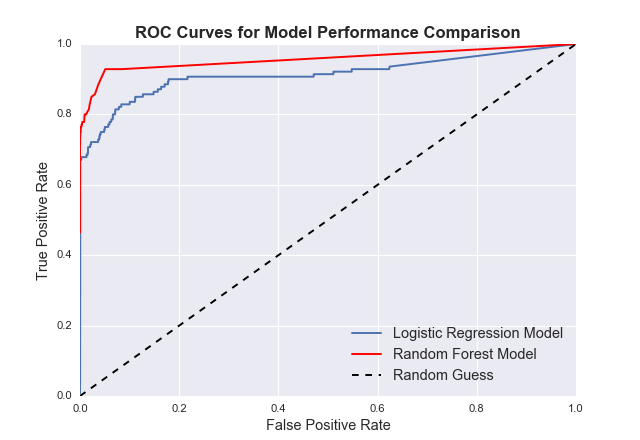

Log. Reg. AUC:  0.913277753574
Rand. For. AUC:  0.957016614519


In [61]:
#Create plot objects and plot TPR vs FPR, add legends and adjust legend position
plt.subplot(1,1,1)
logreg2RocPlot,= plt.plot(logreg2Fpr,logreg2Tpr, label='3 Feat. Log. Reg. Model')
for2RocPlot,= plt.plot(forpred2Fpr,forpred2Tpr, label= '3 Feat. Rand. For. Model', color= 'red')
guessPlot,= plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize= 13)
plt.ylabel('True Positive Rate', fontsize= 13)
plt.title('ROC Curves for Model Performance Comparison', size= 15, fontweight= 'bold')
plt.legend([logreg2RocPlot,for2RocPlot, guessPlot], ['Logistic Regression Model','Random Forest Model', 'Random Guess'], loc=4, fontsize= 13)

print 'Log. Reg. AUC: ', logreg2Auc
print 'Rand. For. AUC: ', forpred2Auc

<a id= 'summary'></a>

## Summary and conclusions

In this notebook, we used supervised machine learning to build statistical models that predict what employees receive OtherPay compensation that is comparable in magnitude to their BasePay (ie. 'extremely high compensation'). Unlike the other components that make up total salaries, OtherPay is vague and if unregulated, could leave room for inefficiencies and/or corruption. Thus, a model that can accurately predict which public workers will exceed a threshold could be useful for internal auditing of the city of San Francisco. 

We were able to access a database and load data on the salary components of public servants in SF and focused on data from 2012. After cleaning and standardizing the dataset, we developed dummy variables to categorize our results into above or below the threshold. After training our models for three and four feature versions of logistic regression and random forest models, we discovered that the accuracies of our predictions improved after removing the TitleLen feature and that random forest models were less sensitive to the noisy TitleLen feature than logistic regression. When narrowed to three feature models for logistic regression and random forests, ROC plots and AUC measurements further distinguished their performance by showing that the random forest model predictions were slightly more accurate than the logistic regression predictions. <i>Thus, our preferred model for threshold predictions was the <strong>three feature random forest model</strong></i>.

Since not all employees apparently receive BasePay compensation, future work could include adding a lower-bound threshold to not include those employees. We could also apply our methods to predict thresholds in sequential years, and map the dynamic range of our prediction accuracy by varying the threshold level. 